Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from itertools import combinations
from math import sqrt
from numpy.linalg import inv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
import statsmodels.formula.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

!pip install --upgrade openpyxl

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Uploading Dataset

In [ ]:
#Load the dataset
from google.colab import files
file = files.upload()  #upload file into google colab session

Saving dataset.csv to dataset.csv


Loading dataset

In [ ]:
df = pd.read_csv("dataset.csv") 

In [ ]:
df.head()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,...,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,Unnamed: 83,hospital_death
0,66154,25312,118,68.0,22.73,0,Caucasian,M,180.3,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,NaN,0
1,114252,59342,81,77.0,27.42,0,Caucasian,F,160.0,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,NaN,0
2,119783,50777,118,25.0,31.95,0,Caucasian,F,172.7,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,NaN,0
3,79267,46918,118,81.0,22.64,1,Caucasian,F,165.1,Operating Room / Recovery,...,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,NaN,0
4,92056,34377,33,19.0,NaN,0,Caucasian,M,188.0,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,NaN,0


From the above sample of the data, we can see a few redundant variables like 'encounter_id','patient_id', 'hospital_id','ice_admit_source','icu_id', 'icu_stay_type' and 'icu_type' which are not constructive in determining the final outcome of whether a patient will survive or not, hence we decicded to drop them.

# DATA PRE_PROCESSING

In [ ]:
df.drop(['encounter_id','hospital_id','patient_id', 'icu_admit_source',
             'icu_id', 'icu_stay_type', 'icu_type'], axis = 1, inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 78 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            87485 non-null  float64
 1   bmi                            88284 non-null  float64
 2   elective_surgery               91713 non-null  int64  
 3   ethnicity                      90318 non-null  object 
 4   gender                         91688 non-null  object 
 5   height                         90379 non-null  float64
 6   pre_icu_los_days               91713 non-null  float64
 7   weight                         88993 non-null  float64
 8   apache_2_diagnosis             90051 non-null  float64
 9   apache_3j_diagnosis            90612 non-null  float64
 10  apache_post_operative          91713 non-null  int64  
 11  arf_apache                     90998 non-null  float64
 12  gcs_eyes_apache                89812 non-null 

"Unnamed: 83" is a column of only null values hence removing it

In [ ]:
df = df.drop(['Unnamed: 83'], axis = 1)

replacing missing bmi, height and weight with the mean of the other patients whose gender and age match with the patients whose columns are missing. 

In [ ]:
df['bmi'] = df.groupby(["age",'gender'])['bmi'].transform(lambda x: x.fillna(x.mean()))
df['height'] = df.groupby(["age",'gender'])['height'].transform(lambda x: x.fillna(x.mean()))
df['weight'] = df.groupby(["age",'gender'])['weight'].transform(lambda x: x.fillna(x.mean()))

dropping rows with more than 8 null values in it since imputaion of too many variables is not desirable

In [ ]:
df = df.dropna(thresh=69)

In [ ]:
df['gcs'] = df['gcs_eyes_apache']+df['gcs_motor_apache']+df['gcs_verbal_apache']

# DATA VISUALIZATION

NUMERICAL AND CATEGORICAL COLUMNS SEPARATION

In [ ]:
categorical = ['elective_surgery', 'ethnicity', 'apache_3j_bodysystem',
               'apache_2_bodysystem', 'apache_post_operative','arf_apache',
               'gcs_eyes_apache','gcs_motor_apache', 'gcs_unable_apache','gcs_verbal_apache','intubated_apache','ventilated_apache',
                 'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 
                 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis',
                 'hospital_death','gender']
numerical_data = df.loc[:, ~df.columns.isin(categorical)]
categorical_data = df.loc[:, df.columns.isin(categorical)]

FULL CORR PLOT

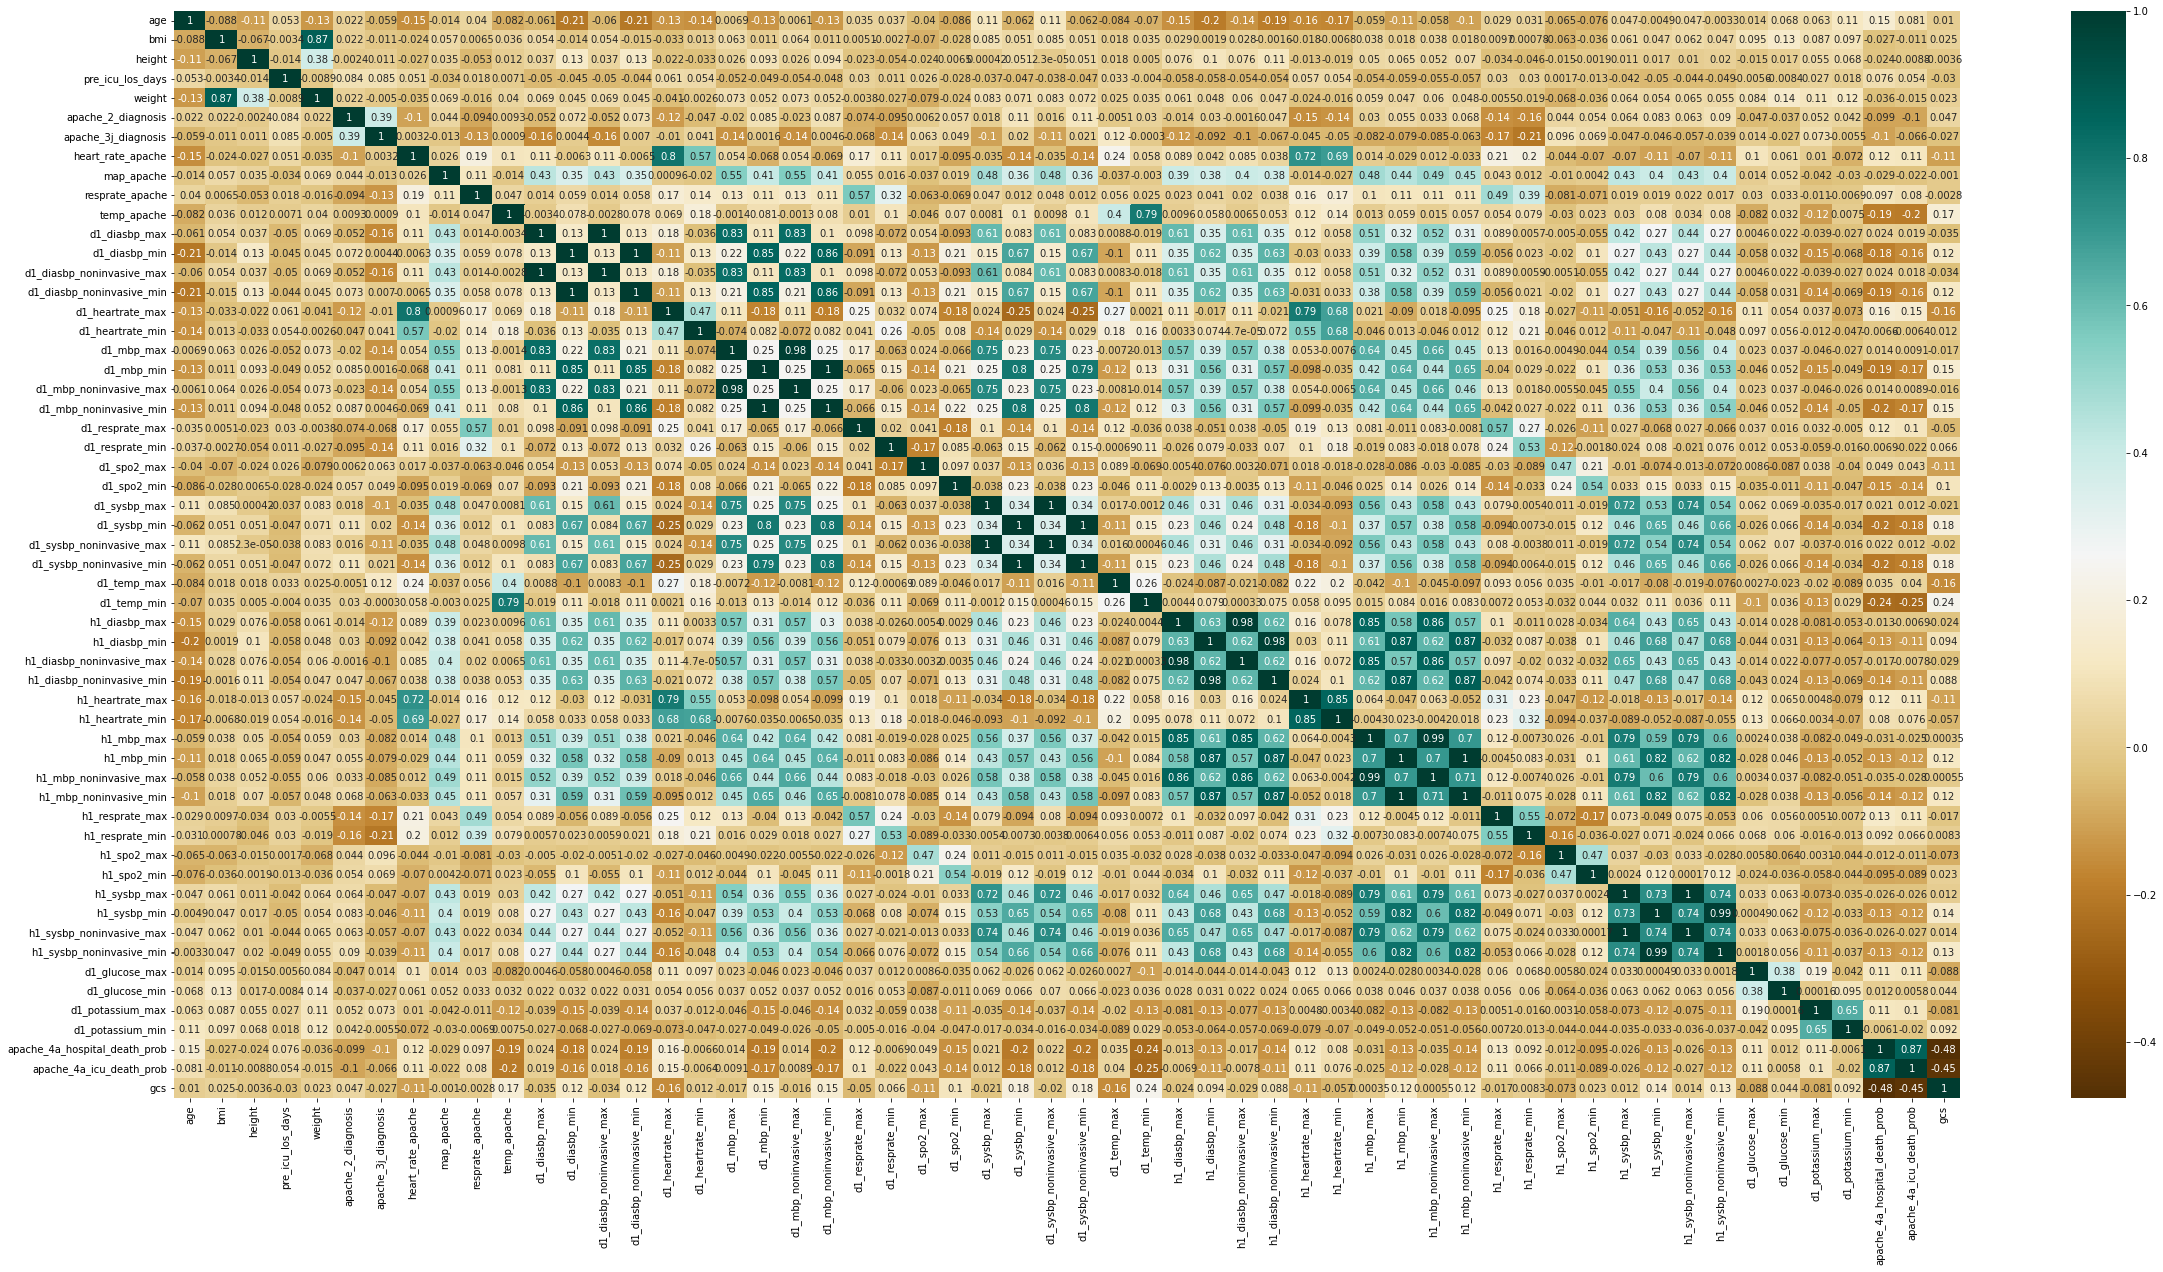

In [ ]:
dfCorr = numerical_data.corr()
plt.figure(figsize=(40,20))
sns.heatmap(dfCorr, annot=True, cmap="BrBG")

SHOWING ONLY COLUMNS WITH A CORRELATION OF MORE THAN 0.8 WITH ANOTHER COLUMN

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


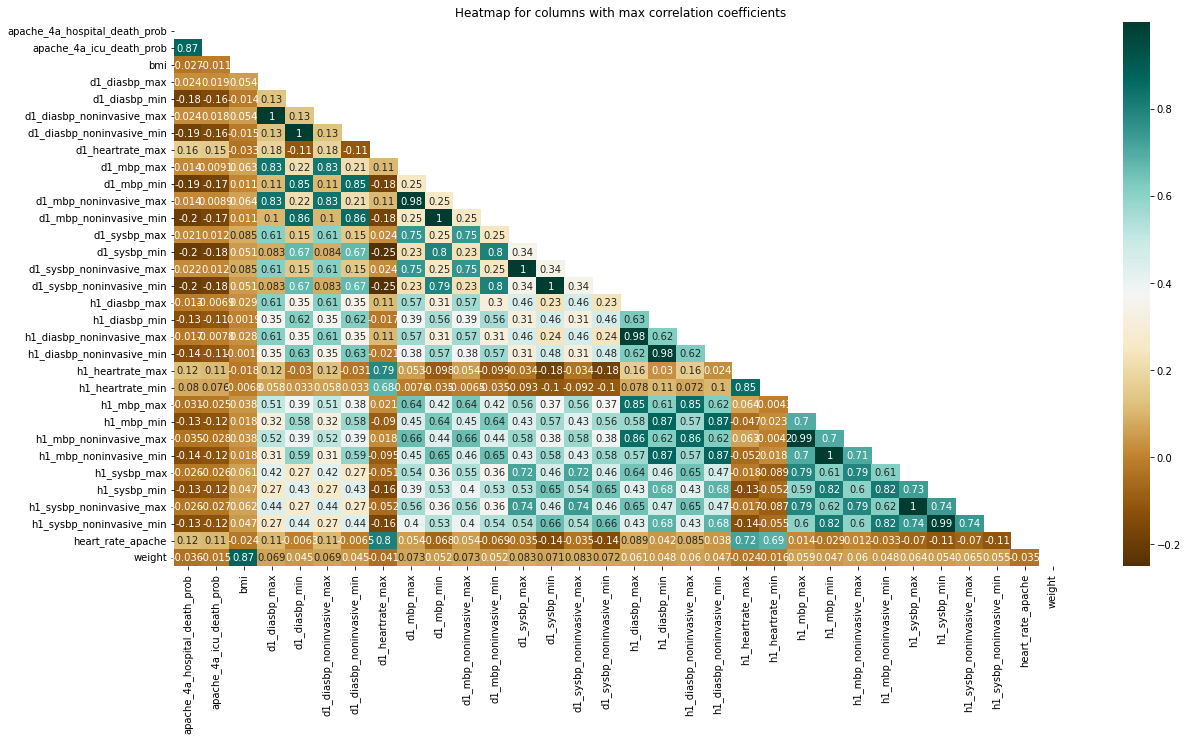

In [ ]:
def absHighPass(df, absThresh):
    passed = set()
    for (r,c) in combinations(df.columns, 2):
        if (abs(df.loc[r,c]) >= absThresh):
            passed.add(r)
            passed.add(c)
    passed = sorted(passed)
    return df.loc[passed,passed]

mask = np.zeros_like(absHighPass(dfCorr,0.8), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(20,10))
sns.heatmap(absHighPass(dfCorr,0.8),annot= True,cmap="BrBG",mask=mask)
plt.title("Heatmap for columns with max correlation coefficients")
plt.savefig('heatmap.png', dpi = 500)
plt.show()


In [ ]:
df = df.drop(['d1_diasbp_noninvasive_max','d1_diasbp_noninvasive_min',
              "d1_sysbp_noninvasive_min",'d1_sysbp_noninvasive_max',
              "h1_mbp_noninvasive_min",'h1_mbp_noninvasive_max',
              'h1_sysbp_noninvasive_min','h1_sysbp_noninvasive_max',
              'h1_diasbp_noninvasive_max','h1_diasbp_noninvasive_min',
              'd1_mbp_noninvasive_min','d1_mbp_noninvasive_max',
              "d1_diasbp_max","d1_diasbp_min","h1_diasbp_min","h1_diasbp_min",
              'h1_heartrate_min','weight','height','h1_diasbp_max',
              'h1_sysbp_min','d1_heartrate_max','apache_4a_icu_death_prob'],
              axis = 1)

In [ ]:
df.shape

(85996, 55)

In [ ]:
from pandas.core.frame import DataFrame
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, threshold=0.9):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    for i in range(len(au_corr)):
      if(au_corr[i]>threshold):
        n=i
      else:
        break
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(numerical_data))

Top Absolute Correlations
d1_diasbp_max  d1_diasbp_noninvasive_max    0.997931
d1_diasbp_min  d1_diasbp_noninvasive_min    0.997103
d1_sysbp_min   d1_sysbp_noninvasive_min     0.996867
d1_sysbp_max   d1_sysbp_noninvasive_max     0.996804
h1_mbp_min     h1_mbp_noninvasive_min       0.996645
h1_sysbp_max   h1_sysbp_noninvasive_max     0.996327
d1_mbp_min     d1_mbp_noninvasive_min       0.995742
h1_sysbp_min   h1_sysbp_noninvasive_min     0.987849
h1_mbp_max     h1_mbp_noninvasive_max       0.986389
d1_mbp_max     d1_mbp_noninvasive_max       0.984693
h1_diasbp_max  h1_diasbp_noninvasive_max    0.984275
dtype: float64


BOX PLOTS

ValueError: ignored

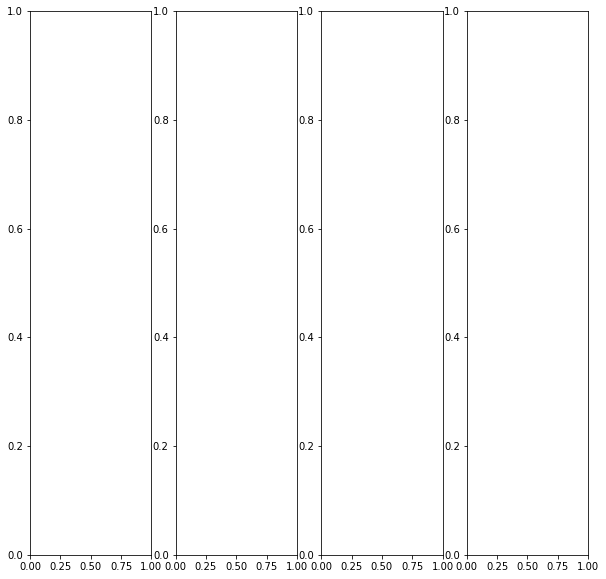

In [ ]:
fig, (axs1,axs2,axs3,axs4) = plt.subplots(1, 4, figsize=(10,10))
sns.boxplot(ax=axs1,y="height", x="hospital_death",
                 data=df)
axs1.set_title("Height")

sns.boxplot(ax=axs2,y="age", x="hospital_death",
                 data=df)
axs2.set_title("Age")

sns.boxplot(ax=axs3,y="bmi", x="hospital_death",
                 data=df)
axs3.set_title("BMI")

sns.boxplot(ax=axs4,y="weight", x="hospital_death",
                 data=df)
axs4.set_title("Weight")
plt.savefig('botplots.png')

Gender Distribution

In [ ]:
plot = px.histogram(df[['age','gender','hospital_death']].dropna(), x="age", y="hospital_death", color="gender")
#plt.savefig('histogram.png')
plot.show()

In [ ]:
f_avg_death=df[df['gender']=='F'][['age','hospital_death']].groupby('age').mean()
m_avg_death=df[df['gender']=='M'][['age','hospital_death']].groupby('age').mean()

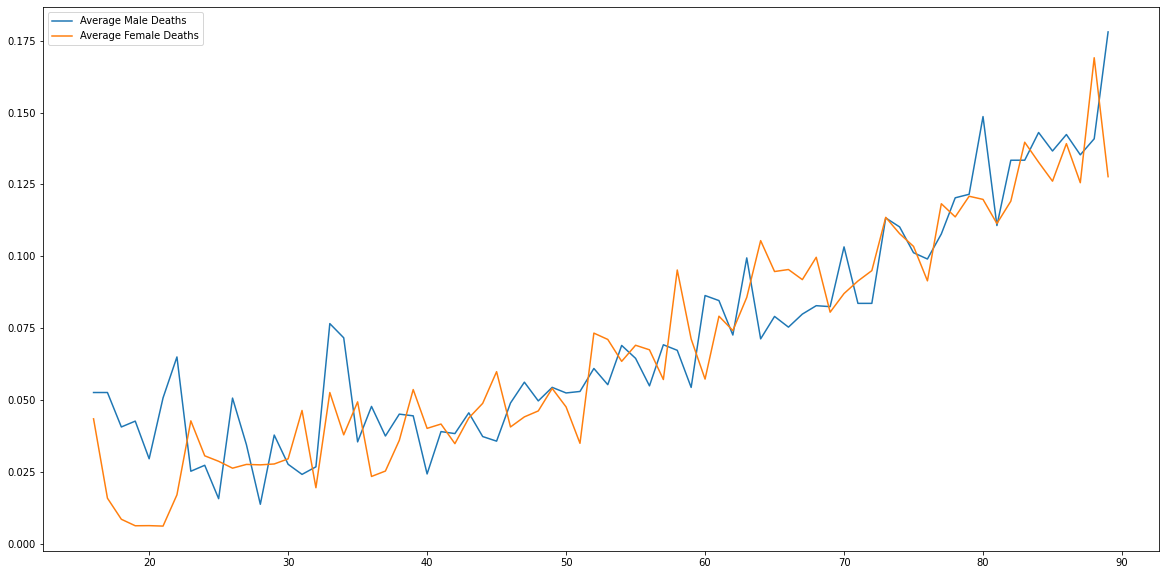

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(20,10))
ax1.plot(m_avg_death.index, m_avg_death.values, label = "Average Male Deaths")
ax1.plot(f_avg_death.index, f_avg_death.values, label = "Average Female Deaths")
plt.legend()
plt.savefig('linegraph.png')
plt.show()

APACHE 3J bodysystem variation

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning:

Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.



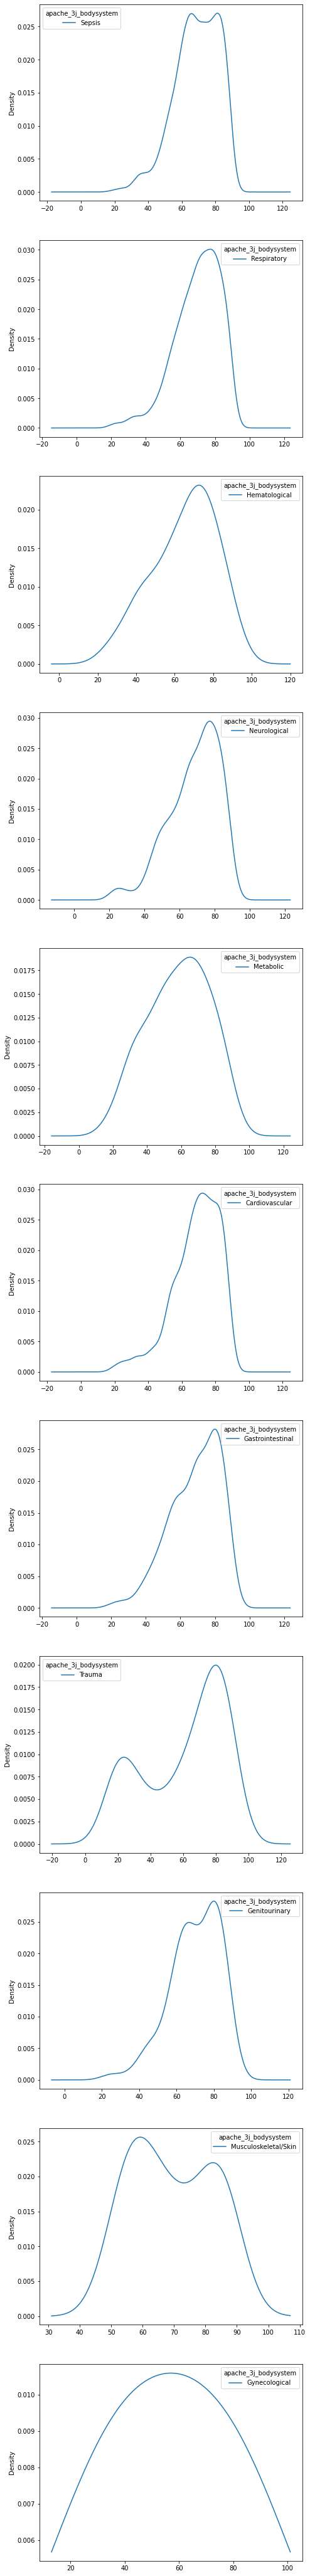

In [ ]:
from operator import indexOf
df1 = df[df['hospital_death'] == 1].dropna()
df1[['age','apache_3j_bodysystem']].groupby('age').mean()
#data_wide = df1.pivot(columns = 'apache_3j_bodysystem',values = 'age')
systems = list(df1.apache_3j_bodysystem.unique())
fig, axs = plt.subplots(len(systems), figsize=(7.5,75))
for s in systems:
  ind = systems.index(s)
  apache3j = df1[df1['apache_3j_bodysystem'].values == s]
  data_wide = apache3j.pivot(columns = 'apache_3j_bodysystem',values = 'age')
  data_wide.plot.density(ax=axs[ind])

#data_wide.plot.density(figsize = (15, 15),linewidth = 2)
#data_wide
plt.savefig('density.png', dpi = 750)


# DATA CLEANING FOR MODEL FITTING

In [ ]:
df = pd.read_csv("dataset.csv") 

In [ ]:
df.drop(['encounter_id','hospital_id','patient_id', 'icu_admit_source',
         'icu_id', 'icu_stay_type', 'icu_type','Unnamed: 83'],
         axis = 1, inplace = True)
df['bmi'] = df.groupby(["age",'gender'])['bmi'].transform(lambda x: x.fillna(x.mean()))
df['height'] = df.groupby(["age",'gender'])['height'].transform(lambda x: x.fillna(x.mean()))
df['weight'] = df.groupby(["age",'gender'])['weight'].transform(lambda x: x.fillna(x.mean()))
df = df.dropna(thresh=69)

In [ ]:
categorical = ['elective_surgery', 'ethnicity', 'apache_3j_bodysystem',
               'apache_2_bodysystem', 'apache_post_operative','arf_apache',
               'gcs_eyes_apache','gcs_motor_apache', 'gcs_unable_apache',
               'gcs_verbal_apache','intubated_apache','ventilated_apache',
               'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 
               'immunosuppression', 'leukemia', 'lymphoma',
               'solid_tumor_with_metastasis','hospital_death','gender']
               
encode = ['ethnicity', 'gender', 'apache_3j_bodysystem', 'apache_2_bodysystem']

numerical_data = df.loc[:, ~df.columns.isin(categorical)]
categorical_data = df.loc[:, df.columns.isin(categorical)]

In [ ]:
df.drop(['d1_diasbp_noninvasive_max','d1_diasbp_noninvasive_min',
              "d1_sysbp_noninvasive_min",'d1_sysbp_noninvasive_max',
              "h1_mbp_noninvasive_min",'h1_mbp_noninvasive_max',
              'h1_sysbp_noninvasive_min','h1_sysbp_noninvasive_max',
              'h1_diasbp_noninvasive_max','h1_diasbp_noninvasive_min',
              'd1_mbp_noninvasive_min','d1_mbp_noninvasive_max',
              "d1_diasbp_max","d1_diasbp_min","h1_diasbp_min","h1_diasbp_min",
              'h1_heartrate_min','weight','height','h1_diasbp_max',
              'h1_sysbp_min','d1_heartrate_max','apache_4a_icu_death_prob'],
              axis = 1, inplace = True)

In [ ]:
df.shape

(85996, 55)

In [ ]:
for col in df.columns:
  if col in categorical:
    df[col].fillna(df[col].mode()[0], inplace=True)
  else:
    df[col].fillna(df[col].mean(), inplace=True)

In [ ]:
numerical_data = df.loc[:, ~df.columns.isin(categorical)]
categorical_data = df.loc[:, df.columns.isin(categorical)]

In [ ]:
df.head()

,age,bmi,elective_surgery,ethnicity,gender,pre_icu_los_days,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,hospital_death
0,68.0,22.73,0,Caucasian,M,0.541667,113.0,502.01,0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,0
1,77.0,27.42,0,Caucasian,F,0.927778,108.0,203.01,0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,0
2,25.0,31.95,0,Caucasian,F,0.000694,122.0,703.03,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,0
3,81.0,22.64,1,Caucasian,F,0.000694,203.0,1206.03,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,0
5,67.0,27.56,0,Caucasian,M,0.000694,301.0,403.01,0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic,0


# ENCODING SPLITTING SCALING

In [ ]:
#ENCODING
#df_enc = df.copy()
#df_enc = pd.get_dummies(df_enc,columns = encode)

#splitting
X = df.copy()
X.drop(['hospital_death'], axis = 1, inplace = True)
y = df["hospital_death"]


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75,
                                                    stratify=y)
X_train.columns = X.columns
X_test.columns = X.columns

X_enc_train = pd.get_dummies(X_train,columns = encode)
X_enc_test = pd.get_dummies(X_test,columns = encode)

#scaling
X_train_sca, X_test_sca = X_train.copy(), X_test.copy()
X_enc_train_sca, X_enc_test_sca = X_enc_train.copy(), X_enc_test.copy()
for col in X_train_sca.columns:
  if col in numerical_data.columns:
    X_test_sca[col] = (X_test_sca[col]-X_train_sca[col].mean())/X_train_sca[col].std()
    X_train_sca[col] = (X_train_sca[col]-X_train_sca[col].mean())/X_train_sca[col].std()

X_train_sca['gcs_motor_apache'] = X_train_sca['gcs_motor_apache']/6
X_train_sca['gcs_eyes_apache'] = X_train_sca['gcs_eyes_apache']/4
X_train_sca['gcs_verbal_apache'] = X_train_sca['gcs_verbal_apache']/5

for col in X_enc_train.columns:
  if col in numerical_data.columns:
    X_enc_test_sca[col] = (X_enc_test_sca[col]-X_enc_train_sca[col].mean())/X_enc_train_sca[col].std()
    X_enc_train_sca[col] = (X_enc_train_sca[col]-X_enc_train_sca[col].mean())/X_enc_train_sca[col].std()

X_enc_train_sca['gcs_motor_apache'] = X_enc_train_sca['gcs_motor_apache']/6
X_enc_train_sca['gcs_eyes_apache'] = X_enc_train_sca['gcs_eyes_apache']/4
X_enc_train_sca['gcs_verbal_apache'] = X_enc_train_sca['gcs_verbal_apache']/5

#df-                non encoded   non standardized  not split
#df_enc             encoded       non standardized  not split
#X        features  non encoded   non standardized  not split
#Y        output    non encoded   non standardized  not split
#X_enc    features  encoded       non standardized  not split
#Y_enc    output    encoded       non standardized  not split

In [ ]:
import sklearn.metrics as metrics
def metric_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [ ]:
print(X_enc_train.shape, X_test.shape, y_train.shape, y_test.shape)

(64497, 79) (21499, 54) (64497,) (21499,)


In [ ]:
#data = pd.read_csv("dataset.csv")
#data.drop(['encounter_id','hospital_id','patient_id', 'icu_admit_source',
#         'icu_id', 'icu_stay_type', 'icu_type','Unnamed: 83'],
#         axis = 1, inplace = True)

Oversampling

In [ ]:
X_os = X_enc_train_sca.copy()
from imblearn.over_sampling import RandomOverSampler
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
Xos_over, yos_over = oversample.fit_resample(X_os, y_train)



In [ ]:
X_os_enc = X_enc_train.copy()
from imblearn.over_sampling import RandomOverSampler
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
Xos_over_enc, yos_over_enc = oversample.fit_resample(X_os_enc, y_train)

In [ ]:
print(Xos_over_enc.shape)

(117878, 79)


# KNN Classifier

In [ ]:
error = []

for i in range(3, 16 , 2):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(Xos_over, yos_over)
    pred_i = knn.predict(X_enc_test_sca)
    error.append(np.mean(pred_i != y_test))


Text(0, 0.5, 'Mean Error')

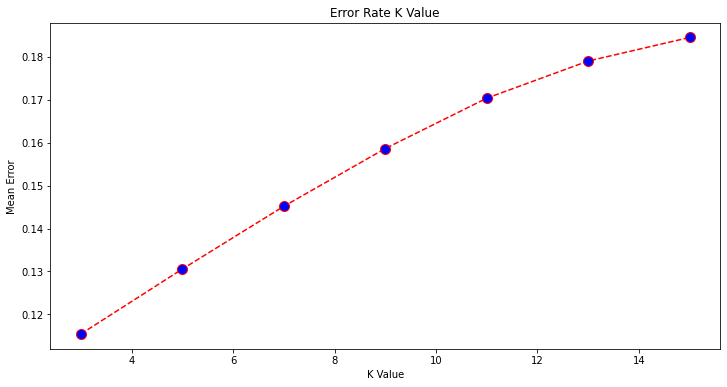

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(3, 16 , 2), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(Xos_over, yos_over)
#y_pred = knn.predict(Xos_over)
#print(confusion_matrix(yos_over, y_pred))
#print(classification_report(yos_over, y_pred))
y_pred = knn.predict(X_enc_test_sca)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[18398  1248]
 [ 1234   619]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     19646
           1       0.33      0.33      0.33      1853

    accuracy                           0.88     21499
   macro avg       0.63      0.64      0.63     21499
weighted avg       0.88      0.88      0.88     21499



# Logistic regression


In [ ]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(Xos_over, yos_over)
y_pred = logreg.predict(X_enc_test_sca)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_enc_test_sca, y_test)))
print(confusion_matrix(y_test, logreg.predict(X_enc_test_sca)))
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.80
[[15784  3862]
 [  414  1439]]
              precision    recall  f1-score   support

           0       0.97      0.80      0.88     19646
           1       0.27      0.78      0.40      1853

    accuracy                           0.80     21499
   macro avg       0.62      0.79      0.64     21499
weighted avg       0.91      0.80      0.84     21499



# Naive Bayes


In [ ]:


gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_enc_train, y_train)

#Predict the response for test dataset
y_pred = gnb.predict(X_enc_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.810177217545002
              precision    recall  f1-score   support

           0       0.96      0.82      0.89     19646
           1       0.27      0.68      0.38      1853

    accuracy                           0.81     21499
   macro avg       0.62      0.75      0.64     21499
weighted avg       0.90      0.81      0.84     21499

[[16151  3495]
 [  586  1267]]


In [ ]:
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(Xos_over_enc, yos_over_enc)

#Predict the response for test dataset
y_pred = gnb.predict(Xos_over_enc)
print("Accuracy:",accuracy_score(yos_over_enc, y_pred))
print(classification_report(yos_over_enc, y_pred))
print(confusion_matrix(yos_over_enc, y_pred))

Accuracy: 0.7623220617927009
              precision    recall  f1-score   support

           0       0.75      0.78      0.77     58939
           1       0.77      0.75      0.76     58939

    accuracy                           0.76    117878
   macro avg       0.76      0.76      0.76    117878
weighted avg       0.76      0.76      0.76    117878

[[45901 13038]
 [14979 43960]]


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

                                      feature  importance       std
61         apache_3j_bodysystem_Gynecological    0.000016  0.000036
42                                       aids    0.000045  0.000068
77    apache_2_bodysystem_Undefined Diagnoses    0.000115  0.000147
64  apache_3j_bodysystem_Musculoskeletal/Skin    0.000245  0.000216
48                                   lymphoma    0.000269  0.000194
..                                        ...         ...       ...
24                                d1_spo2_min    0.031296  0.017258
20                                 d1_mbp_min    0.034105  0.023421
17                          ventilated_apache    0.036725  0.045979
26                               d1_sysbp_min    0.044834  0.030361
41              apache_4a_hospital_death_prob    0.127215  0.076596

[79 rows x 3 columns]


<Figure size 2880x1440 with 0 Axes>

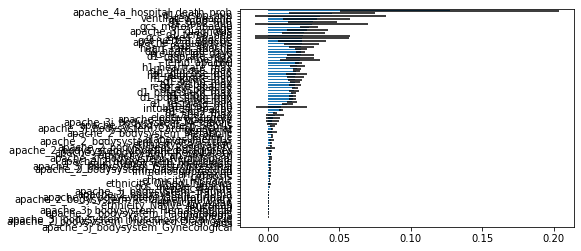

[[19379   267]
 [ 1356   497]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     19646
           1       0.65      0.27      0.38      1853

    accuracy                           0.92     21499
   macro avg       0.79      0.63      0.67     21499
weighted avg       0.91      0.92      0.91     21499



In [ ]:
rf = RandomForestClassifier(n_estimators=500, random_state=1)
rf.fit(Xos_over_enc, yos_over_enc)
#Xos_over_enc, yos_over_enc

# variable (feature) importance plot
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

df = pd.DataFrame({'feature': X_enc_train.columns, 'importance': importances, 'std': std})
df = df.sort_values('importance')
print(df)

plt.figure(figsize=(40,20))
ax = df.plot(kind='barh', xerr='std', x='feature', legend=False)
ax.set_ylabel('')
plt.show()

# confusion matrix for validation set
print(confusion_matrix(y_test, rf.predict(X_enc_test)))
print(classification_report(y_test, rf.predict(X_enc_test)))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
max_accuracy = 0

for x in range(2000):
    rf = RandomForestClassifier(random_state=x)
    rf.fit(X_train,y_train)
    Y_pred_rf = rf.predict(X_test)
    current_accuracy = round(accuracy_score(y_pred_rf,y_test)*100,2)
    if(current_accuracy>max_accuracy):
        max_accuracy = current_accuracy
        best_x = x
#print(max_accuracy)
#print(best_x)
rf = RandomForestClassifier(random_state=best_x)
rf.fit(X_train,y_train)
Y_pred_rf = rf.predict(X_test)
score_rf = round(accuracy_score(Y_pred_rf,y_test)*100,2)
print("The accuracy score we have achieved using Decision Tree is: "+str(score_rf)+" %")

# Gradient Boosting

In [ ]:
boost = GradientBoostingClassifier()
boost.fit(Xos_over_enc, yos_over_enc)
print(confusion_matrix(y_test, boost.predict(X_enc_test)))
print(classification_report(y_test, boost.predict(X_enc_test)))

[[15932  3714]
 [  397  1456]]
              precision    recall  f1-score   support

           0       0.98      0.81      0.89     19646
           1       0.28      0.79      0.41      1853

    accuracy                           0.81     21499
   macro avg       0.63      0.80      0.65     21499
weighted avg       0.92      0.81      0.85     21499



XGBoosting

In [ ]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(Xos_over_enc, yos_over_enc)
Y_pred_xgb = xgb_model.predict(X_enc_test)
score_xgb = round(accuracy_score(Y_pred_xgb,y_test)*100,2)
print("The accuracy score we have achieved using XGBoost is: "+str(score_xgb)+" %")
print(confusion_matrix(y_test, Y_pred_xgb))
print(classification_report(y_test, Y_pred_xgb))

The accuracy score we have achieved using XGBoost is: 81.13 %


In [ ]:
print(confusion_matrix(y_test, Y_pred_xgb))

[[16001  3645]
 [  411  1442]]


# Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(2), activation='tanh', solver='adam',
                    random_state=1)

clf.fit(Xos_over_enc, yos_over_enc)
print(confusion_matrix(y_test, clf.predict(X_enc_test)))
print(classification_report(y_test, clf.predict(X_enc_test)))

[[15557  4089]
 [  452  1401]]
              precision    recall  f1-score   support

           0       0.97      0.79      0.87     19646
           1       0.26      0.76      0.38      1853

    accuracy                           0.79     21499
   macro avg       0.61      0.77      0.63     21499
weighted avg       0.91      0.79      0.83     21499



In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(2), activation='relu', solver='adam',
                    random_state=1)

clf.fit(Xos_over_enc, yos_over_enc)
print(confusion_matrix(y_test, clf.predict(X_enc_test)))
print(classification_report(y_test, clf.predict(X_enc_test)))

[[16739  2907]
 [  584  1269]]
              precision    recall  f1-score   support

           0       0.97      0.85      0.91     19646
           1       0.30      0.68      0.42      1853

    accuracy                           0.84     21499
   macro avg       0.64      0.77      0.66     21499
weighted avg       0.91      0.84      0.86     21499



In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(2), activation='logistic', solver='adam',
                    random_state=1)

clf.fit(Xos_over_enc, yos_over_enc)
print(confusion_matrix(y_test, clf.predict(X_enc_test)))
print(classification_report(y_test, clf.predict(X_enc_test)))

[[14074  5572]
 [  290  1563]]
              precision    recall  f1-score   support

           0       0.98      0.72      0.83     19646
           1       0.22      0.84      0.35      1853

    accuracy                           0.73     21499
   macro avg       0.60      0.78      0.59     21499
weighted avg       0.91      0.73      0.79     21499



In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(2), activation='relu', solver='adam', 
                    max_iter=1000, random_state=1)

clf.fit(Xos_over_enc, yos_over_enc)
print(confusion_matrix(y_test, clf.predict(X_enc_test)))
print(classification_report(y_test, clf.predict(X_enc_test)))

[[16739  2907]
 [  584  1269]]
              precision    recall  f1-score   support

           0       0.97      0.85      0.91     19646
           1       0.30      0.68      0.42      1853

    accuracy                           0.84     21499
   macro avg       0.64      0.77      0.66     21499
weighted avg       0.91      0.84      0.86     21499



# Support Vector Machine

In [ ]:
from sklearn import svm
mod = svm.SVC()

mod.fit(Xos_over_enc, yos_over_enc)
print(confusion_matrix(y_test, mod.predict(X_enc_test)))
print(classification_report(y_test, mod.predict(X_enc_test)))

[[15090  4556]
 [  487  1366]]
              precision    recall  f1-score   support

           0       0.97      0.77      0.86     19646
           1       0.23      0.74      0.35      1853

    accuracy                           0.77     21499
   macro avg       0.60      0.75      0.60     21499
weighted avg       0.91      0.77      0.81     21499



# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
max_accuracy = 0
for x in range(200):
    dt = DecisionTreeClassifier(random_state=x)
    dt.fit(Xos_over_enc, yos_over_enc)
    Y_pred_dt = dt.predict(X_enc_test)
    current_accuracy = round(accuracy_score(Y_pred_dt,y_test)*100,2)
    if(current_accuracy>max_accuracy):
        max_accuracy = current_accuracy
        best_x = x

dt = DecisionTreeClassifier(random_state=best_x)
dt.fit(Xos_over_enc, yos_over_enc)
Y_pred_dt = dt.predict(X_enc_test)
score_dt = round(accuracy_score(Y_pred_dt,y_test)*100,2)
print("The accuracy score we have achieved using Decision Tree is: "+str(score_dt)+" %")

The accuracy score we have achieved using Decision Tree is: 88.38 %
